# Imports

In [1]:
%load_ext autoreload
%autoreload 2


import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
import spikeA
from spikeA.Neuron import Simulated_grid_cell
from spikeA.Animal_pose import Animal_pose
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from spikeA.Neuron import Neuron
import datetime


In [2]:
%run ../../setup_project.py
%run ../../generic_plot_functions.py
%run neural_ds.py
%run sim_grid_func.py

In [3]:
projectName, dataPath, dlcModelPath, myProject, sSessions = setup_project_session_lists(projectName="autopi_mec",dataPath=PROJECT_DATA_PATH,dlcModelPath="")

creating myProject, an autopipy.project object
Project name: autopi_mec
dataPath: /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt/
dlcModelPath: 
Reading /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt//sessionList
We have 180 testing sessions in the list
spikeA.Kilosort_session objects are in sSessions


# Data prep

In [4]:
onlyOF = myProject.dataPath + "/results/jp451_lstm_firstRF.npy"
lastOF = myProject.dataPath + "/results/jp451_lstm_lastRF.npy"

seed_value = 42
np.random.seed(seed_value)

In [5]:
SIM_REANCHOR_ROOT = myProject.dataPath + "/results/simReanchor/"
if not os.path.exists(SIM_REANCHOR_ROOT):
    os.makedirs(SIM_REANCHOR_ROOT)

# Functions

In [6]:
def plotMap(
    ax,
    myMap,
    title="",
    titleY=0.95,
    titleFontSize=10,
    transpose=True,
    cmap="jet",
    vmin=0,
    alpha=1,
):
    """
    Plot one 2D map
    """
    if transpose:
        ax.imshow(
            myMap.T,
            origin="lower",
            cmap=cmap,
            interpolation=None,
            vmin=vmin,
            alpha=alpha,
        )
    else:
        ax.imshow(
            myMap, origin="lower", cmap=cmap, interpolation=None, vmin=vmin, alpha=alpha
        )
    ax.set_title(title, y=titleY, fontsize=titleFontSize)
    ax.set_aspect("equal", adjustable="box")
    ax.axis("off")

In [7]:
def get_ifr_pose_time_from_pose(test_neuron_list, lap, lastTimePose):

    test_pose = np.stack(
        [lap.pose[:, 0], lap.pose[:, 1], lap.pose[:, 2]]
    ).T  # only consider the data that we will be using

    for n in test_neuron_list:
        n.spatial_properties.firing_rate_map_2d()

    ifrList = []
    stList = []
    for i, n in tqdm(enumerate(test_neuron_list)):
        n.spike_train.instantaneous_firing_rate(
            bin_size_sec=0.02, sigma=2, shift_start_time=0.02
        )
        ifrList.append(n.spike_train.ifr[0])
        stList.append(n.spike_train.st + lastTimePose)
        if i == 0:
            time = n.spike_train.ifr[2]
        n.spike_train.ifr = None  # remove the reference to the numpy array, which can be deleted by garbage collector

    ifr, time = (
        np.stack(ifrList, axis=0),
        time.round(4),
    )  # added the round so that the numbers are not 0.019999999 but 0.02
    test_ifr = ifr.T
    test_time = time

    jumpT = test_neuron_list[0].inter

    print(test_ifr.shape, test_time.shape, test_pose.shape)

    assert test_ifr.shape[0] == test_pose.shape[0]
    assert test_time.shape[0] == test_pose.shape[0]

    return (
        test_ifr,
        test_time,
        test_pose,
        stList,
        test_pose[-1][0],
        np.array(jumpT)[0][1],
    )

In [8]:
import numpy as np
import random
from tqdm import tqdm


def get_ifr_pose_time_from_pose(test_neuron_list, lap, lastTimePose):

    test_pose = np.stack(
        [lap.pose[:, 0], lap.pose[:, 1], lap.pose[:, 2]]
    ).T  # only consider the data that we will be using

    for n in test_neuron_list:
        n.spatial_properties.firing_rate_map_2d()

    ifrList = []
    stList = []
    for i, n in tqdm(enumerate(test_neuron_list)):
        n.spike_train.instantaneous_firing_rate(
            bin_size_sec=0.02, sigma=2, shift_start_time=0.02
        )
        ifrList.append(n.spike_train.ifr[0])
        stList.append(n.spike_train.st + lastTimePose)
        if i == 0:
            time = n.spike_train.ifr[2]
        n.spike_train.ifr = None  # remove the reference to the numpy array, which can be deleted by garbage collector

    ifr, time = (
        np.stack(ifrList, axis=0),
        time.round(4),
    )  # added the round so that the numbers are not 0.019999999 but 0.02
    test_ifr = ifr.T
    test_time = time

    jumpT = test_neuron_list[0].inter


    print(test_ifr.shape, test_time.shape, test_pose.shape)

    assert test_ifr.shape[0] == test_pose.shape[0]
    assert test_time.shape[0] == test_pose.shape[0]

    return (
        test_ifr,
        test_time,
        test_pose,
        stList,
        test_pose[-1][0],
        np.array(jumpT)[0][1],
    )


def generate_sections_and_intervals(file_name, grid_param, jump_sections, seed_value):
    np.random.seed(seed_value)

    lap = Animal_pose()
    lap.load_pose_from_file(file_name=file_name)

    oriPose = lap.pose
    total_length = len(oriPose)

    # Initialize lists to store the results
    sections = []
    testIfr = []
    testTime = []
    testPose = []
    testSt = []
    jumpPoints = []
    jumpIntervals = []

    # Generate random indices to split the array into non-overlapping sections
    random_indices = np.sort(
        np.random.choice(total_length, jump_sections - 1, replace=False)
    )

    print("TOTAL LENGTH: ", total_length)
    print("RANDOM JUMP INIDICES: ", random_indices)

    # Generate a temporary array
    tempArray = f"{SIM_REANCHOR_ROOT}/tempJumpArray.npy"

    # Add the start and end indices to create the sections
    start_index = 0
    previousTime = 0
    grid_paramN = grid_param.copy()

    for idx, end_index in enumerate(random_indices):
        _slice = oriPose[start_index:end_index]
        print("Slice Time: ", _slice[-1, 0])
        jumpPoints.append(_slice[-1, 0])  # Append the first jump
        np.save(tempArray, _slice)

        lap = Animal_pose()
        lap.load_pose_from_file(file_name=tempArray)

        random_number = random.uniform(
            0.2, 0.8
        )  # Generates a random float between 0.2 and 0.8

        print("Random Number: ", random_number)

        if idx != 0:
            grid_paramN["offset"] = (
                grid_paramN["offset"] + random_number * grid_paramN["period"][0]
            )

        if idx == 0:
            test_neuron_list = [
                Simulated_grid_cell(
                    name=f"{i}",
                    offset=grid_param["offset"][i, :],
                    orientation=grid_param["orientation"],
                    period=grid_param["period"],
                    peak_rate=grid_param["peak_rate"][i],
                    ap=lap,
                )
                for i in tqdm(range(grid_param["n_cells"]))
            ]

        else:
            test_neuron_list = [
                Simulated_grid_cell(
                    name=f"{i}",
                    offset=grid_paramN["offset"][i, :],
                    orientation=grid_param["orientation"],
                    period=grid_param["period"],
                    peak_rate=grid_param["peak_rate"][i],
                    ap=lap,
                )
                for i in tqdm(range(grid_param["n_cells"]))
            ]

        _ifr, _time, _pose, _st, _lastTime, _jumpT = get_ifr_pose_time_from_pose(
            test_neuron_list, lap, lastTimePose=previousTime
        )

        testIfr.append(_ifr)
        testTime.append(_time)
        testPose.append(_pose)
        testSt.append(_st)
        jumpIntervals.append(_jumpT)

        print("Jump intervals: ", _jumpT)

        start_index = end_index
        previousTime = _lastTime

    # Add the last section
    _slice = oriPose[start_index:]
    np.save(tempArray, _slice)

    lap = Animal_pose()
    lap.load_pose_from_file(file_name=tempArray)

    random_number = random.uniform(
        0.2, 0.8
    )  # Generates a random float between 0.2 and 0.8
    print("Random Number: ", random_number)

    grid_paramN["offset"] = (
        grid_paramN["offset"] + random_number * grid_paramN["period"][0]
    )

    test_neuron_list = [
        Simulated_grid_cell(
            name=f"{i}",
            offset=grid_paramN["offset"][i, :],
            orientation=grid_param["orientation"],
            period=grid_param["period"],
            peak_rate=grid_param["peak_rate"][i],
            ap=lap,
        )
        for i in tqdm(range(grid_param["n_cells"]))
    ]

    _ifr, _time, _pose, _st, _lastTime, _jumpT = get_ifr_pose_time_from_pose(
        test_neuron_list, lap, lastTimePose=previousTime
    )

    testIfr.append(_ifr)
    testTime.append(_time)
    testPose.append(_pose)
    testSt.append(_st)

    # Load a cell from the original position to get the end of the interval
    lap = Animal_pose()
    lap.load_pose_from_file(file_name=file_name)

    lastNeuron = Simulated_grid_cell(
        name="last",
        offset=grid_paramN["offset"][0, :],
        orientation=grid_param["orientation"],
        period=grid_param["period"],
        peak_rate=grid_param["peak_rate"][0],
        ap=lap,
    )

    lastInterval = lastNeuron.inter[0][1]

    jumpIntervals.append(lastInterval)
    print("Last Jump interval: ", lastInterval)

    np.save(f"{SIM_REANCHOR_ROOT}/jumpPoints.npy", jumpPoints)
    np.save(f"{SIM_REANCHOR_ROOT}/jumpIntervals.npy", jumpIntervals)

    # Return the results
    return sections, testIfr, testTime, testPose, testSt, jumpPoints, jumpIntervals

In [9]:

import random


def create_simulated_grid_cells(
    grid_param, lap, offset_adjustment=0, rotation_adjustment=0, coherentChange=True
):
    if coherentChange:
        offset_adj = offset_adjustment
        rotation_adjustment = rotation_adjustment

        return [
            Simulated_grid_cell(
                name=f"{i}",
                offset=grid_param["offset"][i, :] + offset_adj,
                orientation=grid_param["orientation"] + rotation_adjustment,
                period=grid_param["period"],
                peak_rate=grid_param["peak_rate"][i],
                ap=lap,
            )
            for i in range(grid_param["n_cells"])
        ], offset_adj

    else:

        random_array = np.random.rand(grid_param["n_cells"], 2)

        # Scale and shift the numbers to the range [-0.8, 0.8]
        scaled_array = 1.6 * random_array - 0.8

        offset_adj = scaled_array * grid_param["period"][0]

        return [
            Simulated_grid_cell(
                name=f"{i}",
                offset=grid_param["offset"][i, :] + offset_adj[i, :],
                orientation=grid_param["orientation"] + rotation_adjustment,
                period=grid_param["period"],
                peak_rate=grid_param["peak_rate"][i],
                ap=lap,
            )
            for i in range(grid_param["n_cells"])
        ], offset_adj


def get_ifr_pose_time_from_pose_rotate_jump(test_neuron_list, lap, last_time_pose):
    test_pose = lap.pose[:, :3]  # Assuming pose has at least 3 columns
    poseEnd = test_pose.shape[0]
    poseEndS = poseEnd/50
    
    print('Last time pose: ', last_time_pose)


    ifr_list, st_list, time = [], [], None
    for i, neuron in tqdm(enumerate(test_neuron_list), total=len(test_neuron_list)):
        neuron.spike_train.instantaneous_firing_rate(
            bin_size_sec=0.02, sigma=2, time_start=0,time_end=poseEndS
        )
        ifr_list.append(neuron.spike_train.ifr[0][:poseEnd])
        
        filtered_st = np.array([x for x in neuron.spike_train.st if x <= poseEndS])
        
        if i == 0:
            print(neuron.spike_train.st[-10:])
        
        st_list.append(filtered_st + last_time_pose)
        
        if i == 0:
            time = neuron.spike_train.ifr[2][:poseEnd].round(4)
        neuron.spike_train.ifr = None

    ifr = np.stack(ifr_list, axis=0).T
    jump_time = test_neuron_list[0].inter[0][1]

    assert ifr.shape[0] == test_pose.shape[0], f"IFR shape: {ifr.shape}, Pose shape: {test_pose.shape}"

    return ifr, time, test_pose, st_list, test_pose[-1][0], jump_time


def generate_reanchoring_or_rotation(
    file_name,
    grid_param,
    jump_sections,
    seed_value,
    rotate=False,
    reanchoring=False,
    coherentChange=True,
):
    np.random.seed(seed_value)
    random.seed(seed_value)
    lap = Animal_pose()
    lap.load_pose_from_file(file_name=file_name)
    
    augmentedLap = Animal_pose()
    augmentedLap.load_pose_from_file(file_name=file_name)

    ori_pose = lap.pose
    total_length = len(ori_pose)

    (
        test_ifr,
        test_time,
        test_pose,
        test_st,
        jump_points,
        jump_intervals,
        gridParamChange,
    ) = ([], [], [], [], [], [], [])


    indices = np.linspace(0, total_length, num=jump_sections, endpoint=False)[1:]
    random_indices = np.floor(indices).astype(int)
    print(random_indices)

    start_index, previous_time, jump_cumulative_time = 0, 0, 0
    grid_param_n = grid_param.copy()

    for end_index in random_indices.tolist() + [total_length]:

        print("Start index: ", start_index, "End index: ", end_index)
        _slice = ori_pose[start_index:end_index]
        jump_points.append(_slice[-1, 0])
        lap.pose = _slice
        
        # Since the simulation of grid cells draws spike trains from a poisson distribution, at the two ends, there will be less spikes, which could create a problem when we go deep into the simulation
        # We use a augmented augmentedLap to enlarge the animal position for generating the spikes, then slice the original position
        augmentedLap.pose = ori_pose[start_index:end_index+100]
        
        
        #Remove nans for the first starting column 
        _sliceCleaned = _slice[:,:3]
        # Create a mask where the second column is not NaN
        mask = ~np.isnan(_sliceCleaned[:,0])

        # Apply the mask to filter the array
        filtered_data = _sliceCleaned[mask]
        #print(filtered_data.shape)
        
        startingPose_x = np.nanmedian(filtered_data[:3,1])
        startingPose_y = np.nanmedian(filtered_data[:3,2])
        
        startingPose = [startingPose_x,startingPose_y]

        # Adjust the offset based on the previous jump
        random_number_x = 0
        random_number_y = 0
        
        if reanchoring:

            random_number_x = random.uniform(-0.9, 0.9)
            random_number_y = random.uniform(-0.9, 0.9)
            
            
        offset_adjustment_x = (
            random_number_x * grid_param["period"][0] if start_index != 0 else 0
        )
        offset_adjustment_y = (
            random_number_y * grid_param["period"][1] if start_index != 0 else 0
        )
        offset_adjustment = np.array([offset_adjustment_x, offset_adjustment_y])

        random_rotation = 0

        if rotate:
            random_rotation = (
                random.uniform(0.2, np.pi / 3 * 0.8) if start_index != 0 else 0
            )

            random_rotation = (
                random.uniform(-np.pi * 0.8, np.pi * 0.8) if start_index != 0 else 0
            )

        print(
            "Offset Adjustment: ",
            offset_adjustment,
            " Rotation Adjustment: ",
            random_rotation,
        )

        test_neuron_list, offset_adj = create_simulated_grid_cells(
            grid_param_n, augmentedLap, offset_adjustment, random_rotation, coherentChange
        )
        
        # This is needed because the time for aligning the spikes are recalculated after a simulated grid cell creation
        _, _ = create_simulated_grid_cells(
            grid_param_n, lap, offset_adjustment, random_rotation, coherentChange
        )
        

        _ifr, _time, _pose, _st, _last_time, _jump_t = (
            get_ifr_pose_time_from_pose_rotate_jump(
                test_neuron_list, lap, previous_time
            )
        )
        jump_cumulative_time += _jump_t
        
        # print(_time.shape)
        # print(previous_time)
        # print(_pose.shape)

        test_ifr.append(_ifr)
        test_time.append(_time)
        test_pose.append(_pose)
        test_st.append(_st)
        jump_intervals.append(jump_cumulative_time)
        gridParamChange.append(
            {
                "offset": grid_param_n["offset"] + offset_adj,
                "rotation": random_rotation,
                "startingPosition":startingPose,
                "jumpIntervals":[start_index, end_index]
            }
        )

        start_index = end_index
        previous_time += _last_time

    test_ifrConcat = np.concatenate(test_ifr, axis=0)
    test_time = np.concatenate(test_time, axis=0)
    test_pose_o = np.concatenate(test_pose, axis=0)

    return (
        test_ifrConcat,
        test_time,
        test_pose_o,
        test_st,
        jump_points,
        jump_intervals,
        gridParamChange,
        test_pose,
        test_ifr
    )

In [10]:
def plotReanchoredGridMap(poseFile, inputSpikeTrain, inputInterval=None, show=True):

    animalPoseObject = Animal_pose()
    animalPoseObject.load_pose_from_file(file_name=poseFile)

    testNeuron = Neuron(name="test1")

    testNeuron.set_spike_train(st=inputSpikeTrain)

    testNeuron.set_spatial_properties(
        animal_pose=animalPoseObject
    )  # lap will be changed if the pose object gets changed
    testNeuron.remove_nan_from_ap()

    if inputInterval is not None:
        testNeuron.set_intervals(inputInterval)
    else:
        itv = testNeuron.inter
        testNeuron.set_intervals(itv)

    testNeuron.spatial_properties.firing_rate_map_2d()
    # print(testNeuron.spatial_properties.spike_position())
    if show:
        fig, ax = plt.subplots()
        sns.scatterplot(
            x=testNeuron.spatial_properties.spike_position()[:, 0],
            y=testNeuron.spatial_properties.spike_position()[:, 1],
            color="red",
            alpha=1,
            s=5,
        )
        ax.set_aspect("equal")
        ax.set_xlim(-45, 45)
        ax.set_ylim(-45, 45)
        testNeuron.spike_train.instantaneous_firing_rate(bin_size_sec=0.02, sigma=2)

        
        fig, ax = plt.subplots()
        plotMap(
            ax,
            testNeuron.spatial_properties.firing_rate_map,
            title="{0:.2f} Hz".format(
                np.nanmax(testNeuron.spatial_properties.firing_rate_map)
            ),
        )

    return testNeuron

# Setting up

In [11]:
seed_value = 42
np.random.seed(seed_value)

grid_param = {}
grid_param["n_cells"] = 100
grid_param["orientation"] = np.array([0, np.pi / 3, np.pi / 3 * 2])
grid_spacing = 32
grid_param["period"] = np.array(
    [
        grid_spacing * np.cos(np.pi / 6),
        grid_spacing * np.cos(np.pi / 6),
        grid_spacing * np.cos(np.pi / 6),
    ]
)
grid_param["offset"] = (
    np.random.rand(grid_param["n_cells"], 2) * grid_param["period"][0]
)
peak_rates = np.random.normal(loc=25.0, scale=10.0, size=grid_param["n_cells"])
peak_rates[peak_rates < 5] = 5
grid_param["peak_rate"] = peak_rates

In [12]:
grid_param["offset"]

array([[10.37956025, 26.34696771],
       [20.28561117, 16.59051058],
       [ 4.32371539,  4.32304696],
       [ 1.60966028, 24.00417748],
       [16.65858786, 19.62268288],
       [ 0.57045424, 26.87893028],
       [23.06932717,  5.88451405],
       [ 5.0388813 ,  5.08265487],
       [ 8.43140836, 14.54247682],
       [11.97041149,  8.07077868],
       [16.95616481,  3.86576726],
       [ 8.09614999, 10.15291722],
       [12.63898215, 21.75943453],
       [ 5.53352217, 14.25088279],
       [16.41747412,  1.2872716 ],
       [16.83677682,  4.72570314],
       [ 1.80276263, 26.29628738],
       [26.76037988, 22.40296447],
       [ 8.4417044 ,  2.70676902],
       [18.96202186, 12.19786372],
       [ 3.38202277, 13.72274507],
       [ 0.95300265, 25.19982619],
       [ 7.17152122, 18.36035612],
       [ 8.63839074, 14.41254778],
       [15.15087969,  5.12283694],
       [26.8699174 , 21.48111092],
       [26.03615841, 24.79818296],
       [16.56949026, 25.54772821],
       [ 2.45237615,

In [13]:
# fn = f'{SIM_REANCHOR_ROOT}/grid_param2.pkl'
# pickle.dump(grid_param,open(fn,"wb"))

# Simulate train set

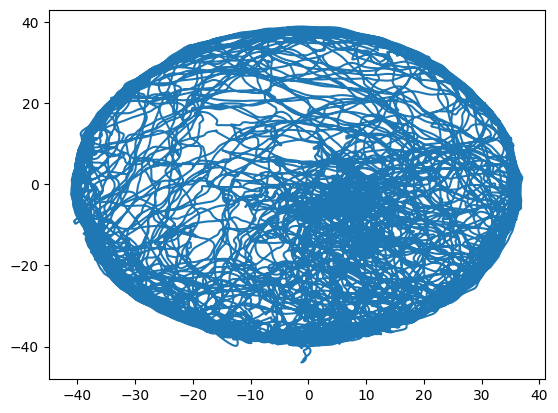

In [14]:
ap = Animal_pose()
ap.load_pose_from_file(file_name=onlyOF)


inter = ap.intervals.inter
# print(inter)
ap.set_intervals(inter)


plt.plot(ap.pose[:, 1], ap.pose[:, 2])
plt.show()

In [15]:
train_neuron_list = [
    Simulated_grid_cell(
        name=f"{i}",
        offset=grid_param["offset"][i, :],
        orientation=grid_param["orientation"],
        period=grid_param["period"],
        peak_rate=grid_param["peak_rate"][i],
        ap=ap,
    )
    for i in tqdm(range(grid_param["n_cells"]))
]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [02:27<00:00,  1.48s/it]


In [16]:
train_pose = np.stack(
    [ap.pose[:, 0], ap.pose[:, 1], ap.pose[:, 2]]
).T  # only consider the data that we will be using
train_pose.shape

(87406, 3)

In [17]:
for n in train_neuron_list:
    n.spatial_properties.firing_rate_map_2d()

In [18]:
ifrList = []
stList = []
for i, n in tqdm(enumerate(train_neuron_list)):
    n.spike_train.instantaneous_firing_rate(
        bin_size_sec=0.02, sigma=2, shift_start_time=0.01
    )
    ifrList.append(n.spike_train.ifr[0])
    stList.append(n.spike_train.st)
    if i == 0:
        time = n.spike_train.ifr[2]
    n.spike_train.ifr = None  # remove the reference to the numpy array, which can be deleted by garbage collector

ifr, time = (
    np.stack(ifrList, axis=0),
    time.round(4),
)  # added the round so that the numbers are not 0.019999999 but 0.02
train_st = stList

train_ifr = ifr.T
train_time = time

100it [00:00, 371.92it/s]


In [19]:
stList[0][-1]

1746.9651

In [20]:
stList[0][1]

0.5312

In [21]:
train_ifr.shape, train_pose.shape, train_time.shape, train_st[0].max()

((87406, 100), (87406, 3), (87406,), 1746.9651)

In [22]:
if train_ifr.shape[0] != train_pose.shape[0]:
    print("Problem with the shape of ifr and pose")
    print(train_ifr.shape,train_pose.shape)
print(train_ifr.shape)

(87406, 100)


# Simulate test set

In [23]:
lap = Animal_pose()
lap.load_pose_from_file(file_name=lastOF)

inter = lap.intervals.inter
lap.set_intervals(inter)

(-50.0, 50.0)

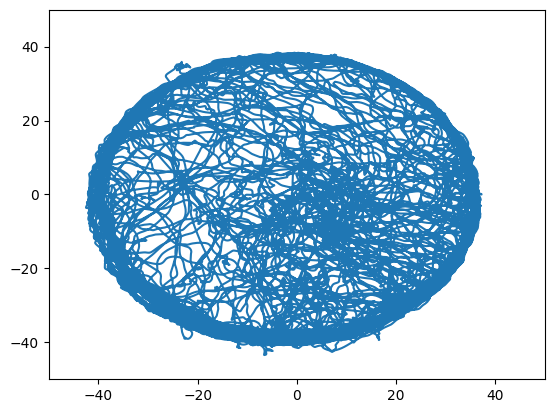

In [24]:
oriPose = lap.pose
plt.plot(oriPose[:, 1], oriPose[:, 2])

plt.xlim(-50, 50)
plt.ylim(-50, 50)

In [25]:
test_neuron_list3 = [
    Simulated_grid_cell(
        name=f"{i}",
        offset=grid_param["offset"][i, :],
        orientation=grid_param["orientation"],
        period=grid_param["period"],
        peak_rate=grid_param["peak_rate"][i],
        ap=lap,
    )
    for i in tqdm(range(grid_param["n_cells"]))
]

100%|██████████| 100/100 [02:22<00:00,  1.42s/it]


In [26]:
testN = test_neuron_list3[0]

In [27]:
testN.spike_train.intervals.inter

array([[   0.        , 1755.01000004]])

In [28]:
lap.pose.shape[0]/50

1755.0

In [29]:
testN.spike_train.instantaneous_firing_rate(
        bin_size_sec=0.02, sigma=2,time_start=0,time_end=1793.9)

In [30]:
testN.spike_train.ifr[0].shape

(87751,)

In [31]:
testN.spike_train.ifr[2].shape


(87751,)

In [32]:
lap.pose[:, 0].shape

(87750,)

In [33]:
test_pose_o = np.stack(
    [lap.pose[:, 0], lap.pose[:, 1], lap.pose[:, 2]]
).T  # only consider the data that we will be using

for n in test_neuron_list3:
    n.spatial_properties.firing_rate_map_2d()

ifrList = []
test_st_list = []
for i, n in tqdm(enumerate(test_neuron_list3)):
    n.spike_train.instantaneous_firing_rate(
        bin_size_sec=0.02, sigma=2, shift_start_time=0.02
    )
    ifrList.append(n.spike_train.ifr[0])
    if i == 0:
        time = n.spike_train.ifr[2]
    n.spike_train.ifr = None  # remove the reference to the numpy array, which can be deleted by garbage collector
    test_st_list.append(n.spike_train.st)

ifr, time = (
    np.stack(ifrList, axis=0),
    time.round(4),
)  # added the round so that the numbers are not 0.019999999 but 0.02

test_ifr_o = ifr.T
test_time_o = time

100it [00:00, 373.51it/s]


In [34]:
test_ifr_o.shape, test_time_o.shape, test_pose_o.shape, time.shape

((87750, 100), (87750,), (87750, 3), (87750,))

In [35]:
if train_ifr.shape[0] != train_pose.shape[0]:
    raise ValueError("Problem with the shape of ifr and pose object")
if test_ifr_o.shape[0] != test_pose_o.shape[0]:
    raise ValueError("Problem with the shape of ifr and pose object")
    
train_grid_coord = poseToGridSpace(pose=train_pose[:,1:3],
                            period=grid_param["period"],
                            orientation=grid_param["orientation"])


test_grid_coord = poseToGridSpace(pose=test_pose_o[:,1:3],
                            period=grid_param["period"],
                            orientation=grid_param["orientation"])

In [36]:
def lossOnTestDataset(model, test_data_loader, device, loss_fn):
    model.eval()
    loss_test = 0
    with torch.no_grad():
        for (
            imgs,
            labels,
            time,
            _,
            _
        ) in (
            test_data_loader
        ):  
            imgs = imgs.to(device=device)  # batch x chan x 28 x 28 to batch x 28 x 28
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            loss_test += loss.item()
    a = model.train()
    return loss_test / len(test_data_loader)

def training_loop(
    n_epochs,
    optimizer,
    model,
    loss_fn,
    train_data_loader,
    test_data_loader,
    config,
    device,
    verbose=False,
    best_loss=float("inf"),
    best_model_state=None,
):

    if verbose:
        print("Training starting at {}".format(datetime.datetime.now()))
    testLoss = lossOnTestDataset(model, test_data_loader, device, loss_fn)
    trainLoss = lossOnTestDataset(model, train_data_loader, device, loss_fn)
    if verbose:
        print("Test loss without training: {}".format(testLoss))

    df = pd.DataFrame(
        {
            "epochs": [0],
            "seq_length": config["seq_length"],
            "n_cells": config["n_cells"],
            "hidden_size": config["hidden_size"],
            "num_layers": config["num_layers"],
            "learning_rate": config["learning_rate"],
            "batch_size": config["batch_size"],
            "train_loss": trainLoss,
            "test_loss": testLoss,
        }
    )

    for epoch in range(1, n_epochs + 1):
        loss_train = 0
        for (
            imgs,
            labels,
            time,
            _,
            _
        ) in (
            train_data_loader
        ):  
            imgs = imgs.to(device=device)  # batch x chan x 28 x 28 to batch x 28 x 28
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()

        testLoss = lossOnTestDataset(model, test_data_loader, device, loss_fn)
        if verbose:
            print(
                "{} Epoch: {}/{}, Training loss: {}, Testing loss: {}".format(
                    datetime.datetime.now(),
                    epoch,
                    n_epochs,
                    loss_train / len(train_data_loader),
                    testLoss,
                )
            )
        df1 = pd.DataFrame(
            {
                "epochs": [epoch],
                "seq_length": config["seq_length"],
                "n_cells": config["n_cells"],
                "hidden_size": config["hidden_size"],
                "num_layers": config["num_layers"],
                "learning_rate": config["learning_rate"],
                "batch_size": config["batch_size"],
                "train_loss": loss_train / len(train_data_loader),
                "test_loss": testLoss,
            }
        )

        df = pd.concat([df, df1])

        if testLoss < best_loss:
            best_loss = testLoss
            best_model_state = model.state_dict()

    return df, best_model_state


def train_lstm(
    config,
    train_grid_coord,
    train_time,
    train_ifr,
    test_grid_coord,
    test_time,
    test_ifr,
    verbose=True,
):
    """
    This only takes the first 4 columns in train_grid_coord and test_grid_coord (v0, v1)
    """

    print(datetime.datetime.now(), config)

    train_dataset = NeuralDatasetSimple(
        ifr=train_ifr[:, : config["n_cells"]],
        pose=train_grid_coord[:, 0:4],
        time=train_time,
        seq_length=config["seq_length"],
        original_position_cartesian=train_grid_coord[:, 0:4],
    )
    ifr_normalization_means = train_dataset.ifr_normalization_means
    ifr_normalization_stds = train_dataset.ifr_normalization_stds

    myDict = {
        "ifr_normalization_means": ifr_normalization_means,
        "ifr_normalization_stds": ifr_normalization_stds,
    }

    # fn = sSes.fileBase+".rnn_ifr_normalization.pkl"
    # print("Saving:",fn)
    # with open(fn, 'wb') as handle:
    #     pickle.dump(myDict, handle)

    test_dataset = NeuralDatasetSimple(
        ifr=test_ifr[:, : config["n_cells"]],
        pose=test_grid_coord[:, 0:4],
        time=test_time,
        seq_length=config["seq_length"],
        original_position_cartesian=test_grid_coord[:, 0:4],  # This is not used here
        ifr_normalization_means=ifr_normalization_means,
        ifr_normalization_stds=ifr_normalization_stds,
    )

    train_data_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=config["batch_size"],
        num_workers=2,
        shuffle=True,
        pin_memory=True,
    )  # to load batches
    test_data_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=config["batch_size"],
        num_workers=2,
        shuffle=False,
        pin_memory=False,
    )  # to load batches

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps")
    model = LSTMSimple(
        config["n_cells"],
        config["hidden_size"],
        config["num_layers"],
        config["num_outputs"],
        config["seq_length"],
        device=device,
    ).to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=config["learning_rate"])
    loss_fn = torch.nn.MSELoss()  #

    model.train()

    best_loss = float("inf")  # Initialize with a large value
    best_model_state = None

    df, best_model_state = training_loop(
        n_epochs=config["num_epochs"],
        optimizer=optimizer,
        model=model,
        loss_fn=loss_fn,
        train_data_loader=train_data_loader,
        test_data_loader=test_data_loader,
        config=config,
        device=device,
        verbose=True,
    )
    return df, model, best_model_state

In [37]:
config = {"seq_length":20,
            "n_cells":train_ifr.shape[1],
            "hidden_size" :256,
            "num_layers" : 2,
            "num_outputs" : 4, # sin and cos of v0 and v1
            "learning_rate" : 0.01,
            "batch_size" :64,
            "num_epochs": 100}

In [38]:
# df, model,best_model_state = train_lstm(config,
#                                 train_grid_coord,train_time,train_ifr,
#                                 test_grid_coord,test_time_o, test_ifr_o)

In [39]:
# fn = f"{SIM_REANCHOR_ROOT}/grid_cell_model2.pt"
# print("saving the model state_dict to",fn)
# torch.save(best_model_state, fn)

# Plot MVL code

In [40]:
GLOBALFONTSIZE = 12

def calculate_circular_mean(values):
    # Convert to numpy array for efficiency
    angles = values

    # Calculate mean of sine and cosine components
    mean_sin = np.nanmean(np.sin(angles))
    mean_cos = np.nanmean(np.cos(angles))

    # Compute the circular mean using arctangent
    mean_angle = np.arctan2(mean_sin, mean_cos)

    # Adjust the angle to be within -pi to pi if necessary
    if mean_angle > np.pi:
        mean_angle -= 2 * np.pi
    elif mean_angle < -np.pi:
        mean_angle += 2 * np.pi

    return mean_angle


def calculate_mvl(inputValues):
    # Step 3: Convert to complex numbers
    complex_data = np.exp(1j * inputValues)

    # Step 4: Calculate the mean vector
    mean_vector = np.nanmean(complex_data)

    # Step 5: Calculate the mean vector length
    mean_vector_length = np.abs(mean_vector)

    return mean_vector_length

def plot_mvl(ax,mvtDirError):
    sns.histplot(mvtDirError,bins=np.linspace(-np.pi,np.pi,20),ax=ax,stat='density',color='#2ec4b6')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel("Dec. directional error",fontsize=GLOBALFONTSIZE)
    ax.set_ylabel("Density",fontsize=GLOBALFONTSIZE)
    
    ax.text(0.05,0.9,f"Dir. precision: {np.round(calculate_mvl(mvtDirError),2)}", transform=ax.transAxes, fontsize=GLOBALFONTSIZE)
    
    ax.set_xticks([-np.pi,0,np.pi])
    ax.set_xticklabels(['$-\pi$','$0$','$\pi$'],fontsize=GLOBALFONTSIZE)
    
    ax.set_ylim(0,1.2)

In [41]:
import os
import pickle
import numpy as np
import pandas as pd
import torch
from scipy.ndimage import gaussian_filter1d

    
def load_pickle(filepath):
    """Load a pickle file from the given filepath."""
    with open(filepath, "rb") as f:
        return pickle.load(f)

def get_test_ifr_filename(dir_path, mode):

    mode_to_filename = {
        "m_reanchor_40": "test_ifr_m_anchor_40.pkl",
        
    }
    return os.path.join(dir_path, mode_to_filename.get(mode, "test_ifr.pkl"))

def load_position_ifr_dataset(
    dir_path=f"{SIM_REANCHOR_ROOT}",
    rotate_or_reanchor='None'
):
    """
    Load training and test datasets (IFR and pose) and grid parameters.
    
    Parameters:
        dir_path (str): Directory where the data files are stored.
        rotate_or_reanchor (str): Specifies which test IFR file to use.
        
    Returns:
        tuple: (train_ifr, train_pose, train_grid_coord, test_ifr, test_pose,
                test_grid_coord, grid_param, train_time, test_time)
    """
    # Load training data
    train_ifr, train_time = load_pickle(os.path.join(dir_path, "train_ifr.pkl"))
    train_pose = load_pickle(os.path.join(dir_path, "train_pose.pkl"))

    # Load test IFR based on the specified mode
    test_ifr_file = get_test_ifr_filename(dir_path, rotate_or_reanchor)
    print(test_ifr_file)
    test_ifr, test_time = load_pickle(test_ifr_file)

    test_pose = load_pickle(os.path.join(dir_path, "test_pose.pkl")) #Previously just test_pose
    grid_param = load_pickle(os.path.join(dir_path, "grid_param2.pkl"))

    print("train_ifr.shape:", train_ifr.shape)
    print("train_pose.shape:", train_pose.shape)
    
    print("test_ifr.shape:", test_ifr.shape)
    print("test_pose.shape:", test_pose.shape)

    # Validate that the number of samples match between IFR and pose data
    if train_ifr.shape[0] != train_pose.shape[0]:
        raise ValueError("Mismatch in number of training samples between IFR and pose.")
    if test_ifr.shape[0] != test_pose.shape[0]:
        raise ValueError("Mismatch in number of test samples between IFR and pose.")

    # Convert poses to grid coordinates
    train_grid_coord = poseToGridSpace(
        pose=train_pose[:, 1:3],
        period=grid_param["period"],
        orientation=grid_param["orientation"]
    )
    test_grid_coord = poseToGridSpace(
        pose=test_pose[:, 1:3],
        period=grid_param["period"],
        orientation=grid_param["orientation"]
    )

    return (train_ifr, train_pose, train_grid_coord,
            test_ifr, test_pose, test_grid_coord,
            grid_param, train_time, test_time)

def run_model_on_loader(model, data_loader, device):
    """
    Run the model on the provided data loader and collect predictions.
    
    Parameters:
        model (torch.nn.Module): The trained model.
        data_loader (torch.utils.data.DataLoader): Data loader for the test dataset.
        device (torch.device): Device to run inference on.
        
    Returns:
        tuple: (predictions, loaded_labels, times) where predictions and labels
               are numpy arrays.
    """
    predictions_list = []
    labels_list = []
    times_list = []
    ori_index_list = []
    cartesian_poseH = []
    
    model.eval()
    with torch.no_grad():
        for imgs, labels, times,ori_index,cartesian_pose in data_loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            predictions_list.append(outputs.cpu().numpy())
            labels_list.append(labels.numpy())
            times_list.append(times.numpy())
            ori_index_list.append(ori_index.numpy())
            cartesian_poseH.append(cartesian_pose.numpy().squeeze())
    
    predictions = np.concatenate(predictions_list, axis=0)
    loaded_labels = np.concatenate(labels_list, axis=0)
    times = np.concatenate(times_list, axis=0)
    ori_index_out = np.concatenate(ori_index_list, axis=0)
    cartesian_poseH = np.concatenate(cartesian_poseH, axis=0)
    
    #print(times.shape)
    
    return predictions, loaded_labels, times, ori_index_out,cartesian_poseH

def compute_movement_metrics(predictions, loaded_labels,ori_index_out,grid_param,cartesian_pose, sigma=5, sampling_rate=1/50):
    """
    Smooth predictions and labels, compute movement paths, and compile movement metrics.
    
    Parameters:
        predictions (np.ndarray): Raw model predictions.
        loaded_labels (np.ndarray): Ground truth labels.
        grid_param (dict): Contains 'period' and 'orientation' for grid conversion.
        sigma (int): Standard deviation for Gaussian smoothing.
        sampling_rate (float): Position sampling rate.
        
    Returns:
        tuple: (predMvt, mvt, result_df) where predMvt and mvt are movement paths,
               and result_df is a DataFrame of computed metrics.
    """
    # Smooth the predictions and labels
    predictions_smoothed = gaussian_filter1d(predictions, sigma=sigma, mode="nearest", axis=0)
    labels_smoothed = gaussian_filter1d(loaded_labels, sigma=sigma, mode="nearest", axis=0)

    # Convert grid coordinates to movement paths
    predMvt = gridSpaceToMovementPath(
        predictions_smoothed, #predictions_smoothed
        grid_period=grid_param["period"],
        orientation=grid_param["orientation"],
    )
    mvt = gridSpaceToMovementPath(
        labels_smoothed, #labels_smoothed
        grid_period=grid_param["period"],
        orientation=grid_param["orientation"],
    )

    # Compute speed (assuming Euclidean distance)
    speed = np.sqrt(np.sum(mvt**2, axis=1)) / sampling_rate

    # Compute movement directions
    mvtDir = np.arctan2(mvt[:, 1], mvt[:, 0])
    predMvtDir = np.arctan2(predMvt[:, 1], predMvt[:, 0])
    mvtDirError = np.arctan2(np.sin(predMvtDir - mvtDir), np.cos(predMvtDir - mvtDir))

    # Build the results DataFrame with additional metrics
    result_df = pd.DataFrame({
        "x": mvt[:, 0],
        "y": mvt[:, 1],
        "px": predMvt[:, 0],
        "py": predMvt[:, 1],
        'cartesian_time':cartesian_pose[:,0],
        'cartesian_x':cartesian_pose[:,1],
        'cartesian_y':cartesian_pose[:,2],
        "speed": speed,
        "mvtDir": mvtDir,
        "predMvtDir": predMvtDir,
        "mvtDirError": mvtDirError,
        "v0_cos": predictions_smoothed[:, 0],
        "v0_sin": predictions_smoothed[:, 1],
        "v1_cos": predictions_smoothed[:, 2],
        "v1_sin": predictions_smoothed[:, 3],
        "lv0_cos": labels_smoothed[:, 0],
        "lv0_sin": labels_smoothed[:, 1],
        "lv1_cos": labels_smoothed[:, 2],
        "lv1_sin": labels_smoothed[:, 3],
        "v0": np.arctan2(predictions_smoothed[:, 1], predictions_smoothed[:, 0]),
        "v1": np.arctan2(predictions_smoothed[:, 3], predictions_smoothed[:, 2]),
        "lv0": np.arctan2(labels_smoothed[:, 1], labels_smoothed[:, 0]),
        "lv1": np.arctan2(labels_smoothed[:, 3], labels_smoothed[:, 2]),
        "ori_index": ori_index_out,
    })
    result_df["dv0"] = result_df["v0"] - result_df["lv0"]
    result_df["dv1"] = result_df["v1"] - result_df["lv1"]

    return predMvt, mvt, result_df

def get_mvl_from_dataset(model,config,rotate_or_reanchor="None"):
    """
    Load the dataset, run the model on test data, and compute movement metrics.
    
    Parameters:
        rotate_or_reanchor (str): Mode to choose the test IFR file.
        
    Returns:
        tuple: (predMvt, mvt, result_df) where:
            - predMvt: Predicted movement paths.
            - mvt: Ground truth movement paths.
            - result_df: DataFrame with detailed movement metrics.
    """
    # Load datasets and grid parameters
    (train_ifr, train_pose, train_grid_coord,
     test_ifr, test_pose, test_grid_coord,
     grid_param, train_time, test_time) = load_position_ifr_dataset(rotate_or_reanchor=rotate_or_reanchor)
    

    # Create training and test datasets (NeuralDatasetSimple and config must be defined elsewhere)
    train_dataset = NeuralDatasetSimple(
        ifr=train_ifr[:, :config["n_cells"]],
        pose=train_grid_coord[:, :4],
        time=train_time,
        seq_length=config["seq_length"],
        original_position_cartesian=train_pose
    )
    test_dataset = NeuralDatasetSimple(
        ifr=test_ifr[:, :config["n_cells"]],
        pose=test_grid_coord[:, :config["num_outputs"]],
        time=test_time,
        seq_length=config["seq_length"],
        ifr_normalization_means=train_dataset.ifr_normalization_means,
        ifr_normalization_stds=train_dataset.ifr_normalization_stds,
        original_position_cartesian=test_pose
    )

    test_data_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=config["batch_size"],
        num_workers=2,
        shuffle=False,
        pin_memory=False,
    )

    # Run model inference on the test data
    predictions, loaded_labels, _, ori_index_out,cartesian_pose = run_model_on_loader(model, test_data_loader, device)

    # Compute movement paths and additional metrics
    predMvt, mvt, result_df = compute_movement_metrics(predictions, loaded_labels, ori_index_out,grid_param,cartesian_pose)

    return predMvt, mvt, result_df, cartesian_pose


In [42]:
config = {"seq_length":20,
            "n_cells":100,
            "hidden_size" :256,
            "num_layers" : 2,
            "num_outputs" : 4, # sin and cos of v0 and v1
            "learning_rate" : 0.01,
            "batch_size" :64,
            "num_epochs": 100}

In [43]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = LSTMSimple(
    config["n_cells"],
    config["hidden_size"],
    config["num_layers"],
    config["num_outputs"],
    config["seq_length"],
    device=device,
).to(device)

In [44]:
fn = f"{SIM_REANCHOR_ROOT}/grid_cell_model2.pt"
model.load_state_dict(torch.load(fn, map_location=device))

<All keys matched successfully>

In [45]:
predMvt, mvt, resultDf_m_reanchor, cartesian_pose = get_mvl_from_dataset(model,config,rotate_or_reanchor='m_reanchor_40')

/ext_drives/d91/data/projects/jingjie/dyrad_data_files/results/simReanchor/test_ifr_m_anchor_40.pkl
train_ifr.shape: (89501, 100)
train_pose.shape: (89501, 3)
test_ifr.shape: (89695, 100)
test_pose.shape: (89695, 3)


In [46]:
# Compute directional metrics as before:
mvtDir = np.arctan2(mvt[:, 1], mvt[:, 0])
predMvtDir = np.arctan2(predMvt[:, 1], predMvt[:, 0])
mvtDirError = np.arctan2(np.sin(predMvtDir - mvtDir), np.cos(predMvtDir - mvtDir))

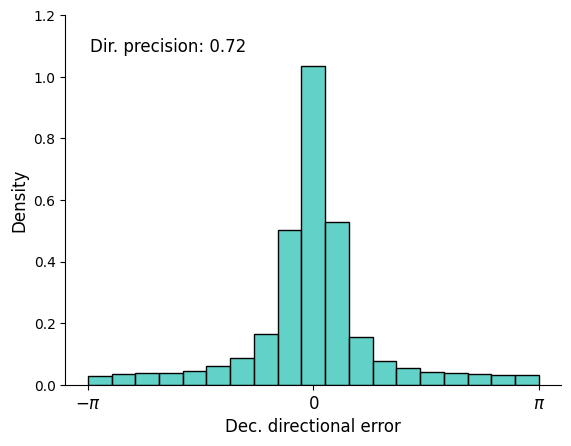

In [47]:
fig, ax = plt.subplots()
plot_mvl(ax,mvtDirError)

# Check within the jump intervals

### Generate new simulated data and save them with the jump indexes

In [48]:
# m_reanchorGenerated = (
#     generate_reanchoring_or_rotation(
#         file_name=lastOF,
#         grid_param=grid_param,
#         jump_sections=40,
#         seed_value=1, 
#         rotate=False,
#         reanchoring=True,
#     )
# )

In [49]:
# positionArray = m_reanchorGenerated[-2]

In [50]:
# positionArray[0].shape

In [51]:
# ifr_first_cell = m_reanchorGenerated[0][:,0]
# ifr_list = m_reanchorGenerated[-1]

In [52]:
# m_testSt = m_reanchorGenerated[3]

# m_test_st_jump = [
#     np.concatenate([element[i] for element in m_testSt]) for i in range(len(m_testSt[0]))
# ]
# m_jumpNeuron = plotReanchoredGridMap(lastOF, m_test_st_jump[5])

In [53]:
# for i in range(len(m_testSt)):
#     print(m_testSt[i][0][:10])
#     print(m_testSt[i][0][-10:])

In [54]:
# n1 = m_jumpNeuron
# fig, ax0 = plt.subplots()
# plotMap(
#     ax0,
#     n1.spatial_properties.firing_rate_map,
#     title="{0:.2f} Hz".format(np.nanmax(n1.spatial_properties.firing_rate_map)),
# )

In [55]:
def save_reanchoring_or_rotation_files(inputDict,folderPath =f'{SIM_REANCHOR_ROOT}',savePath='_r_'):
    ifr, time, pose, spike_train, _, jumpIntervals, gridParams,_,_ = inputDict
    
    assert ifr.shape[0] == pose.shape[0]
    
    #Save the generated IFR
    fn = os.path.join(folderPath,f"test_ifr{savePath}.pkl")
    pickle.dump((ifr,time),open(fn,"wb"))
    
    print('Saved ifr to:',fn)
    #Save the generated pose file
    fn = os.path.join(folderPath,f"test_pose{savePath}.pkl")
    pickle.dump(pose,open(fn,"wb"))
    
    print('Saved pose to:',fn)
    
    #Save the spike train data
    fn = os.path.join(folderPath,f"test_st{savePath}.pkl")
    pickle.dump(spike_train,open(fn,"wb"))
    
    print('Saved spike train to:',fn)
    
    #Save the jump intervals
    fn = os.path.join(folderPath,f"test_ji{savePath}.pkl")
    pickle.dump(jumpIntervals,open(fn,"wb"))
    
    print('Saved jump intervals to:',fn)
    
    #Save the grid params
    fn = os.path.join(folderPath,f"test_grid{savePath}.pkl")
    pickle.dump(gridParams,open(fn,"wb"))
    
    print('Saved grid params to:',fn)

In [56]:
# save_reanchoring_or_rotation_files(m_reanchorGenerated,savePath='_m_anchor_40')

In [57]:
# def match_array_to_df(position_array, df, row_num=None, tol=1e-5):
#     """
#     Finds a contiguous segment in the dataframe (with columns 'cartesian_x' and 'cartesian_y')
#     that matches the position data in the numpy array.
    
#     Parameters:
#         position_array (np.ndarray): Array of shape (x, 3) with columns [time, x_position, y_position].
#         df (pd.DataFrame): DataFrame with columns ['cartesian_x', 'cartesian_y'].
#         row_num (int, optional): If provided, only the last `row_num` rows of the array are used for matching.
#         tol (float): Tolerance for floating point comparisons (used in np.allclose).
        
#     Returns:
#         tuple: (match_start, match_end) indices in the dataframe if a match is found, else (None, None).
#     """
#     # Use only the last row_num rows if specified; else use the entire array
#     if row_num is not None:
#         positions = position_array[-row_num:, 1:3]
#     else:
#         positions = position_array[:, 1:3]
    
#     # Get the positions from the dataframe
#     df_positions = df[['cartesian_x', 'cartesian_y']].values
    
#     n_positions = len(positions)
#     total_df = len(df_positions)
    
#     # Slide over the dataframe to find a contiguous matching segment
#     for i in range(total_df - n_positions + 1):
#         # Compare the slice from the dataframe with the numpy positions
#         if np.allclose(df_positions[i:i+n_positions], positions, atol=tol):
#             match_start = i
#             match_end = i + n_positions
#             return match_start, match_end  # Found a matching segment
    
#     # No matching segment found
#     return None, None

In [58]:
# def match_all_arrays(list_of_arrays, df, row_num=None, tol=1e-5):
#     results = []
#     for idx, arr in enumerate(list_of_arrays):
#         start, end = match_array_to_df(arr, df, row_num=row_num, tol=tol)
#         results.append({'array_index': idx, 'match_start': start, 'match_end': end})
#     return pd.DataFrame(results)

In [59]:
#matched_dataframe = match_all_arrays(positionArray, resultDf_m_reanchor)

In [60]:
#jump_indexes_to_focus = matched_dataframe.loc[:,'match_start']

In [61]:
#np.save(f"{SIM_REANCHOR_ROOT}/jump_indexes_to_focus.npy", jump_indexes_to_focus)

### Calculate moving average and make plot

In [62]:
jump_indexes_to_focus = np.load(f"{SIM_REANCHOR_ROOT}/jump_indexes_to_focus.npy")

In [63]:
resultDf_m_reanchor = resultDf_m_reanchor.reset_index(names='time_index')

In [64]:
def apply_a_moving_average_old(inputValue, bin_size_sec=1, min_obs=10):
    inputDf = inputValue.copy()

    inputDf["convertedTime"] = inputDf["ori_index"] / 50

    inputDf["iTime_td"] = pd.to_timedelta(inputDf["convertedTime"], unit="s")

    window_size = pd.Timedelta(seconds=bin_size_sec)

    # Apply the rolling window and calculate the circular mean
    inputDf["circular_mean"] = inputDf.rolling(
        window=window_size, on="iTime_td", min_periods=min_obs
    )["mvtDirError"].apply(calculate_circular_mean, raw=False)
    
    inputDf["mean_vector_length"] = inputDf.rolling(
        window=window_size, on="iTime_td", min_periods=min_obs,center=False
    )["mvtDirError"].apply(calculate_mvl, raw=False)
    
    inputDf["average_speed"] = inputDf.rolling(
        window=window_size, on="iTime_td", min_periods=min_obs,center=False
    )["speed"].mean()
    
    inputDf.drop(columns=["iTime_td"], inplace=True)


    return inputDf

In [65]:
def moving_average_custom(df, column, func, time_col, bin_size_sec, min_obs, center=False):
    """
    Applies a custom moving window function over a DataFrame column based on a time column.
    
    Parameters:
      df (pd.DataFrame): The input DataFrame.
      column (str): Name of the column over which to compute the moving average.
      func (callable): Function to apply to the window (should accept a pandas Series).
      time_col (str): Name of the time column (with dtype timedelta) to use for windowing.
      bin_size_sec (float): The window size in seconds.
      min_obs (int): Minimum number of observations required in the window.
      center (bool): Whether the window should be centered (default False uses trailing window).
      
    Returns:
      list: A list of computed values (or NaN if window has insufficient observations).
    """
    results = []
    # Iterate over each timestamp in the DataFrame.
    for t in df[time_col]:
        if center:
            # Define a symmetric window around t.
            start_time = t - pd.Timedelta(seconds=bin_size_sec/2)
            end_time = t + pd.Timedelta(seconds=bin_size_sec/2)
        else:
            # Define a trailing window ending at t.
            start_time = t - pd.Timedelta(seconds=bin_size_sec)
            end_time = t

        # Select all rows within the window.
        window_vals = df.loc[(df[time_col] >= start_time) & (df[time_col] <= end_time), column]
        if len(window_vals) >= min_obs:
            results.append(func(window_vals))
        else:
            results.append(np.nan)
    return results

def apply_a_moving_average(inputValue, bin_size_sec=1, min_obs=10):
    # Create a copy of the input DataFrame.
    inputDf = inputValue.copy()

    # Convert the index values into seconds and then to a timedelta.
    inputDf["convertedTime"] = inputDf["ori_index"] / 50
    inputDf["iTime_td"] = pd.to_timedelta(inputDf["convertedTime"], unit="s")

    # Apply custom moving window functions:
    # 1. Calculate the circular mean using a trailing window.
    inputDf["circular_mean"] = moving_average_custom(
        inputDf,
        column="mvtDirError",
        func=calculate_circular_mean,
        time_col="iTime_td",
        bin_size_sec=bin_size_sec,
        min_obs=min_obs,
        center=False
    )

    # 2. Calculate the mean vector length using a centered window.
    inputDf["mean_vector_length"] = moving_average_custom(
        inputDf,
        column="mvtDirError",
        func=calculate_mvl,
        time_col="iTime_td",
        bin_size_sec=bin_size_sec,
        min_obs=min_obs,
        center=False
    )

    # 3. Calculate the average speed using a centered window.
    inputDf["average_speed"] = moving_average_custom(
        inputDf,
        column="speed",
        func=lambda x: x.mean(),
        time_col="iTime_td",
        bin_size_sec=bin_size_sec,
        min_obs=min_obs,
        center=False
    )

    # Clean up the temporary time column.
    inputDf.drop(columns=["iTime_td"], inplace=True)
    
    return inputDf


In [66]:
movingAverage_reanchor = apply_a_moving_average(resultDf_m_reanchor,bin_size_sec=1,min_obs=10)

In [67]:
subset_dfs = []  

for jump_index, jump_val in enumerate(jump_indexes_to_focus[:]):

    subset = movingAverage_reanchor[(movingAverage_reanchor['time_index'] >= jump_val - 100) & (movingAverage_reanchor['time_index'] <= jump_val + 100)].copy()
    
    
    # Add jump_index column
    subset['jump_index'] = jump_index
    
    # Add adjusted_time_index column (relative index)
    subset['adjusted_time_index'] = subset['time_index'] - jump_val 
        
    # Append to list of dataframes
    subset_dfs.append(subset)
    
# Concatenate all subset dataframes into one
new_df = pd.concat(subset_dfs, ignore_index=True)


In [68]:
new_df['time_index_to_time'] = new_df['adjusted_time_index'] / 50

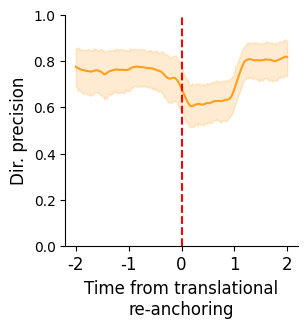

In [69]:
fig, ax = plt.subplots(figsize=(3,3))

def plot_dir_precision_simulation(ax,inputDf,val='mean_vector_length'):
    sns.lineplot(data=inputDf,x='time_index_to_time',y=val,ax=ax,c='#FF9F1C') #mean_vector_length
        
    ax.set_ylabel('Dir. precision',fontsize=GLOBALFONTSIZE)
    ax.set_xlabel('Time from translational\nre-anchoring',fontsize=GLOBALFONTSIZE)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xticks([-2,-1,0,1,2])
    ax.set_xticklabels(['-2','-1','0','1','2'],fontsize=GLOBALFONTSIZE)

    ax.set_ylim(0,1)
    ax.axvline(x=0,ymax=1,color='red',ls='--')
    
plot_dir_precision_simulation(ax,new_df)

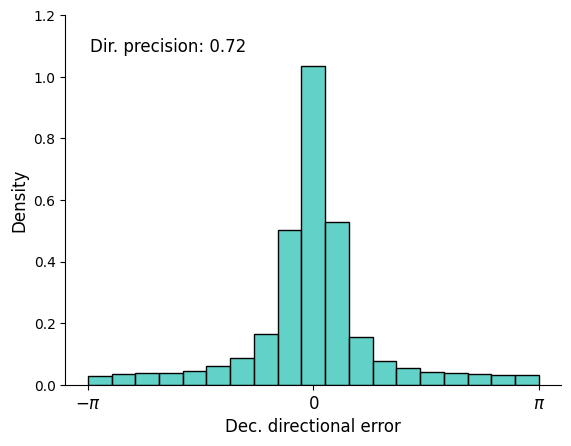

In [70]:
fig, ax = plt.subplots()
plot_mvl(ax,mvtDirError)

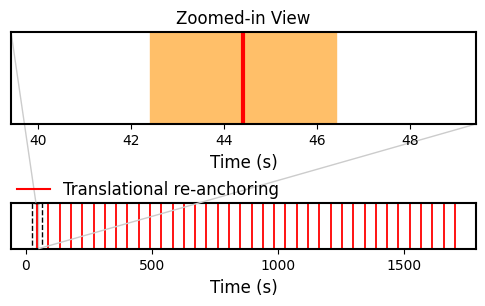

In [71]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset


def plot_inset_with_highlights(ax, jump_indexes_to_focus, movingAverage_reanchor):
    """
    Plot an inset and zoomed-in view on a provided matplotlib axis.

    Parameters:
    - ax: The main matplotlib axis on which the insets will be drawn.
    - jump_indexes_to_focus: Iterable of jump index values.
    - movingAverage_reanchor: DataFrame-like object with an 'ori_index' column.
    - GLOBALFONTSIZE: Font size for labels and titles.
    """
    # Turn off the main axis frame
    ax.axis("off")

    # Compute max and min values from the data
    maximum_value = movingAverage_reanchor.ori_index.max()
    minimum_value = movingAverage_reanchor.ori_index.min()

    # Create inset for the entire interval (lower region)
    axup = inset_axes(ax, width="100%", height="20%", loc="lower center")

    # Plot red vertical lines for each jump index
    for jump_val in jump_indexes_to_focus:
        axup.axvline(x=jump_val / 50, color="red", linewidth=1.3)

    # Choose one jump for zooming (e.g., the second element)
    zoom_jump_val = jump_indexes_to_focus[1]

    # Add a dashed rectangle highlighting the zoom region around the selected jump
    rect = plt.Rectangle(
        (zoom_jump_val / 50 - 20, 0),  # (x, y) lower left corner
        40,  # width
        maximum_value / 50,  # height
        fill=False,
        linestyle="--",
        linewidth=1,
        edgecolor="black",
        zorder=10,
    )
    axup.add_patch(rect)

    # Customize the lower inset (axup)
    axup.set_ylim(0, maximum_value / 50)
    axup.set_yticks([])
    axup.set_xticks([0, 500, 1000, 1500])
    axup.set_xlabel("Time (s)", fontsize=GLOBALFONTSIZE)

    # Add legend for the red line

    # Create a zoomed-in inset (upper region)
    axins = inset_axes(ax, width="100%", height="40%", loc="upper center")

    # Plot a red vertical line at the selected jump index in the zoomed-in view
    axins.axvline(x=zoom_jump_val / 50, color="red", linewidth=3)

    # Highlight a region around the selected jump
    axins.axvspan(
        zoom_jump_val / 50 - 2, zoom_jump_val / 50 + 2, color="#FFBF69", alpha=1
    )

    # Set zoomed-in limits (e.g., 10 unit width centered on the jump)
    zoom_width = 10
    axins.set_xlim(
        zoom_jump_val / 50 - zoom_width / 2, zoom_jump_val / 50 + zoom_width / 2
    )
    axins.set_ylim(0, maximum_value / 50)
    axins.set_yticks([])
    axins.set_xlabel("Time (s)", fontsize=GLOBALFONTSIZE)

    axins.set_title("Zoomed-in View", fontsize=GLOBALFONTSIZE)
    # axup.set_title('Entire interval', fontsize=GLOBALFONTSIZE)

    # Make the spines thicker for both insets
    for inset in [axup, axins]:
        for spine in inset.spines.values():
            spine.set_linewidth(1.5)

    # Connect the two insets with lines
    mark_inset(axup, axins, loc1=2, loc2=4, fc="none", ec="0.8")

    

    red_line = mlines.Line2D(
        [], [], color="red", linewidth=1.5, label="Translational re-anchoring"
    )
    axins.legend(
        handles=[red_line],
        loc="upper left",
        fontsize=GLOBALFONTSIZE,
        frameon=False,
        bbox_to_anchor=(-0.02, -0.45),
    )
    
    axins.title.set_zorder(11)
    axup.title.set_zorder(11)
    axins.legend_.set_zorder(11)


fig, ax = plt.subplots(figsize=(6, 3))
plot_inset_with_highlights(ax, jump_indexes_to_focus, movingAverage_reanchor)
plt.show()

# Make final figure

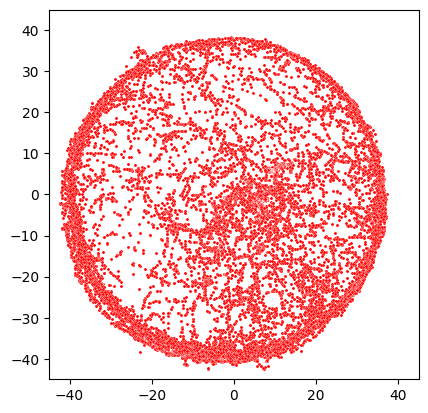

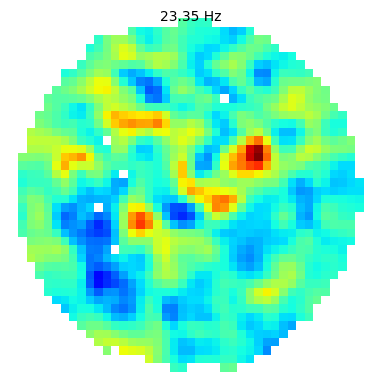

In [72]:
m_testSt = load_pickle(f"{SIM_REANCHOR_ROOT}/test_st_m_anchor_40.pkl")
m_test_st_jump = [
    np.concatenate([element[i] for element in m_testSt]) for i in range(len(m_testSt[0]))
]
n1 = plotReanchoredGridMap(lastOF, m_test_st_jump[5])

In [73]:
def add_text(ax, x, y, label, fw="normal"):
    ax.text(
        x,
        y,
        label,
        style="normal",
        fontweight=fw,
        fontsize=GLOBALFONTSIZE + 4,
        verticalalignment="center",
        horizontalalignment="center",
        transform=ax.transAxes,
    )

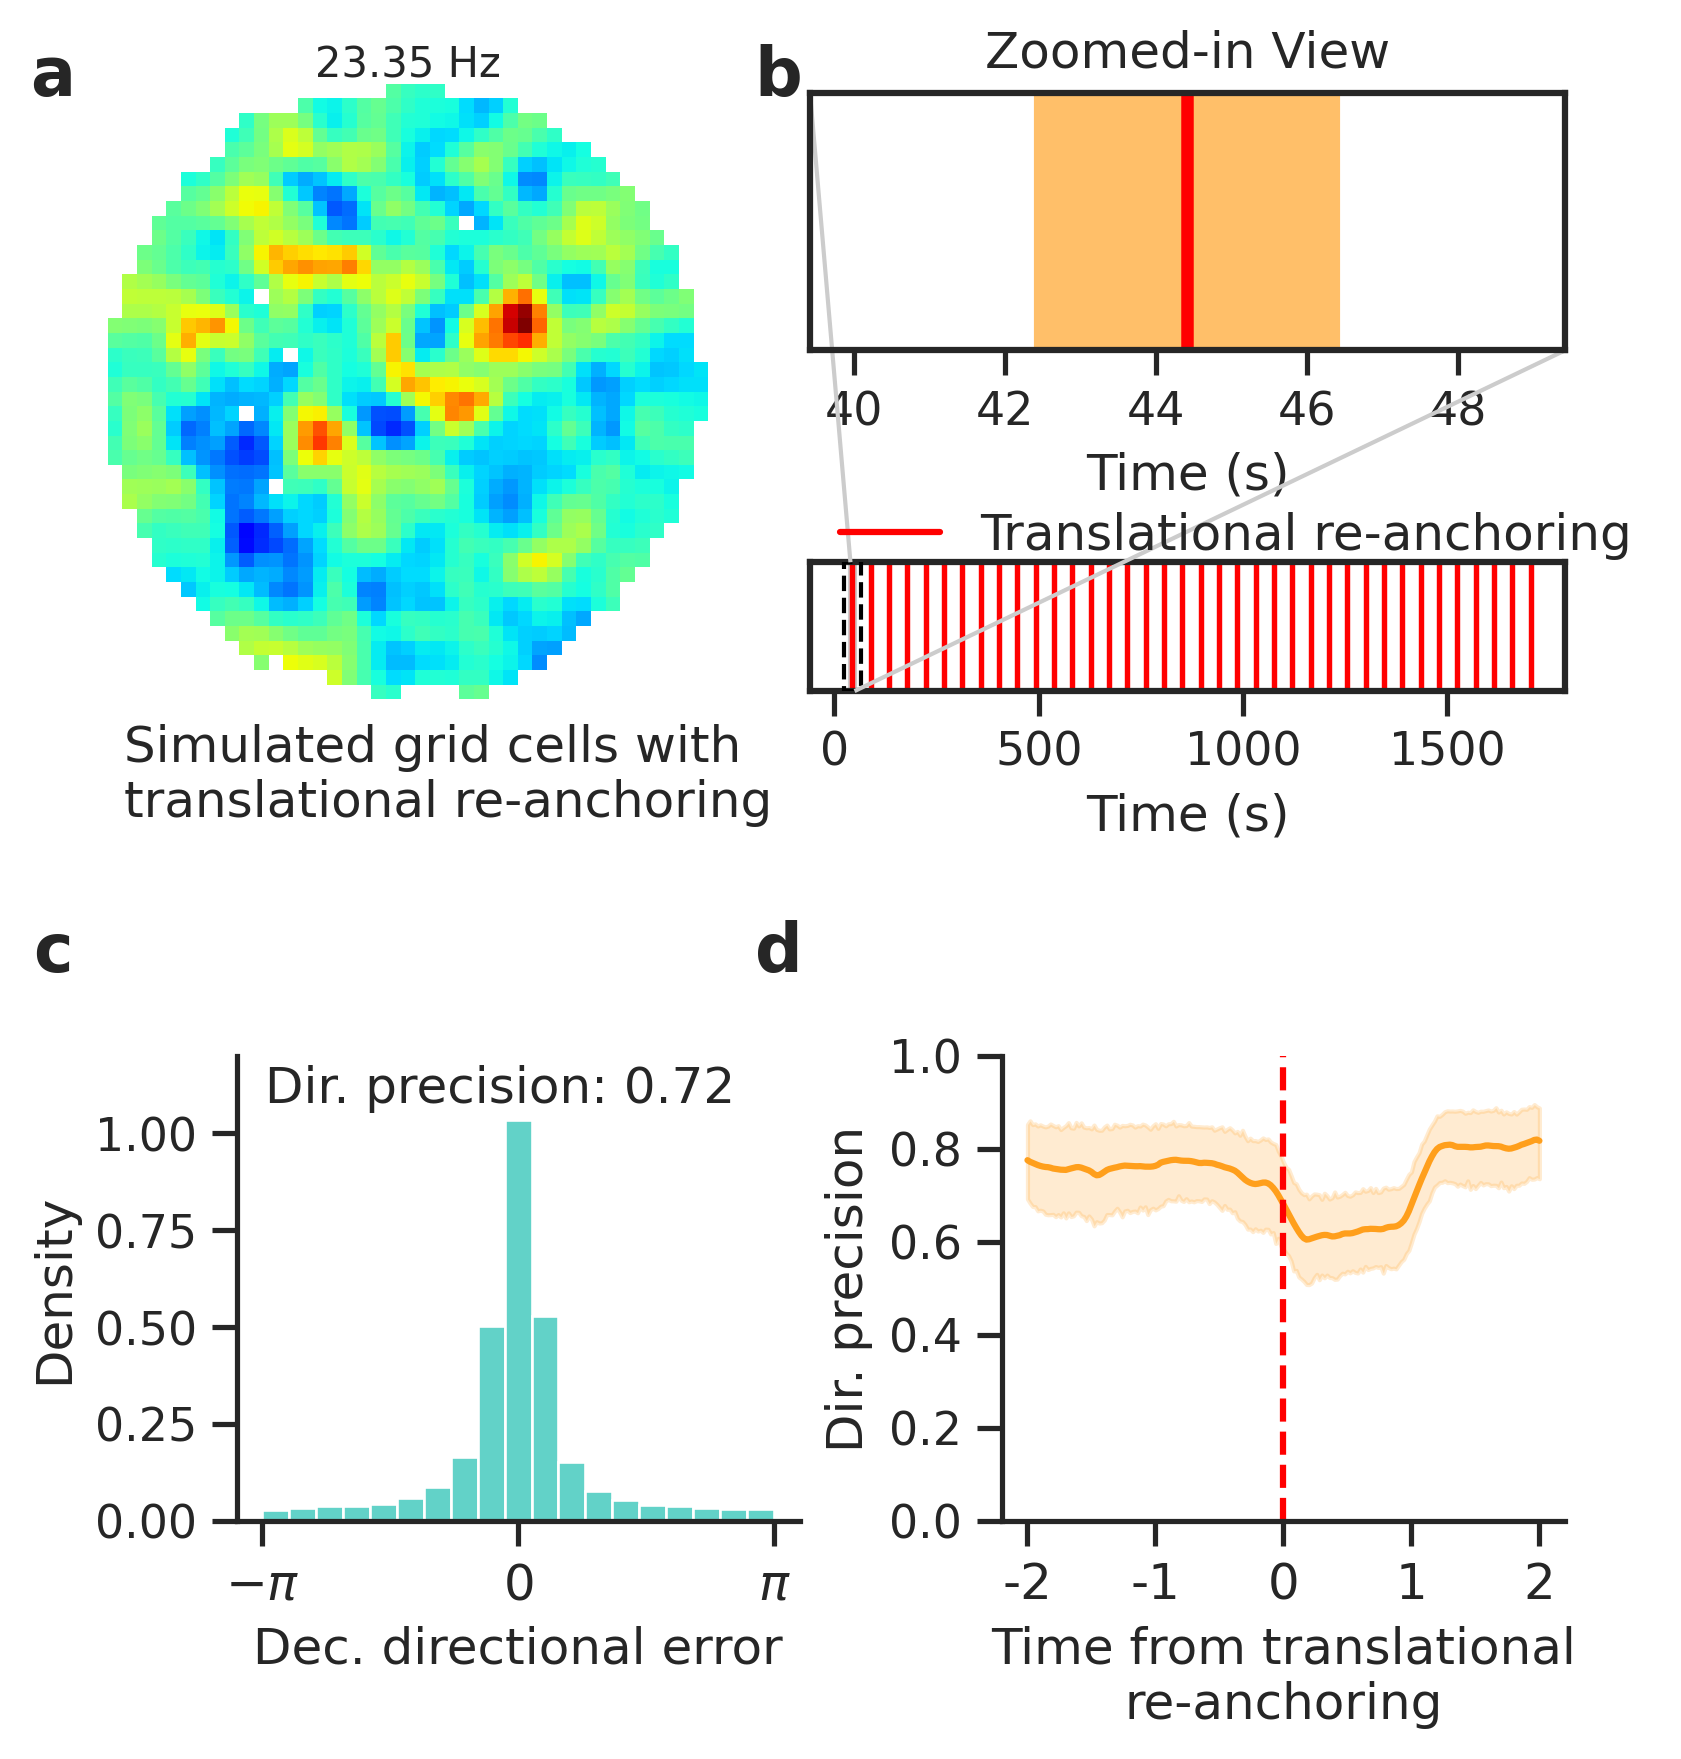

In [74]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

nrows = 3
ncols = 2
colSize = 2.6
rowSize = 1.9
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})

#Data Used For Making the Plot
sns.set_theme(style = 'ticks')

fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
gs = GridSpec(nrows,ncols,figure = fig,height_ratios=[0.9,0.26,1]) # create a grid layout


gsStats = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[2,:])

ax0 = fig.add_subplot(gs[0,0])
plotMap(
    ax0,
    n1.spatial_properties.firing_rate_map,
    title="{0:.2f} Hz".format(np.nanmax(n1.spatial_properties.firing_rate_map)),
)
ax0.text(0.05,-0.16,'Simulated grid cells with\ntranslational re-anchoring', transform=ax0.transAxes, fontsize=GLOBALFONTSIZE)

ax0 = fig.add_subplot(gs[0,1])
plot_inset_with_highlights(ax0, jump_indexes_to_focus, movingAverage_reanchor)

# NOTE Add stats
ax0 = fig.add_subplot(gsStats[0,0])
plot_mvl(ax0,mvtDirError)

ax0 = fig.add_subplot(gsStats[0,1])
plot_dir_precision_simulation(ax0,new_df)

gs1 = GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[:,:])
#***********************************#
ax0 = fig.add_subplot(gs1[:,:])

#Add figure legend
add_text(ax0,0,1,'a',fw='900')
add_text(ax0,0.48,1,'b',fw='900')

add_text(ax0,0,0.47,'c',fw='900')
add_text(ax0,0.48,0.47,'d',fw='900')

ax0.axis('off')
###

plt.savefig('../../Output/Sup_Figure9.pdf', bbox_inches='tight', dpi=300)